# Gemini thinking

LLMs have traditionally generated responses in a direct, stream-of-consciousness manner. However, Google's Gemini 2.5 introduces a "thinking" capability that allows the model to engage in internal reasoning before producing its final output. This notebook explores how to leverage this thinking feature through LangChain's integration, demonstrating how controlled reasoning can significantly improve response quality for complex tasks.

The thinking mechanism works by allocating a specific token budget for internal reasoning processes. During this phase, the model can work through problems step-by-step, consider multiple approaches, and refine its understanding before generating the final response. This is particularly valuable for mathematical problems, logical puzzles, and analytical tasks where systematic reasoning leads to more accurate results.

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import Dict, Any
import time

# Load environment variables from .env file
load_dotenv()

# Set up API key
os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')

### Understanding thinking budgets
The thinking budget is the core mechanism that controls how much computational effort Gemini dedicates to internal reasoning. Think of it as giving the model "time to think" before responding - similar to how humans might pause to consider a complex question before answering.

In [2]:
# Initialize Gemini with thinking capabilities enabled
llm_thinking = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    thinking_budget=1024,  # Allocate 1024 tokens for internal reasoning
    temperature=0.7  # Moderate creativity in responses
)

# Create a complex mathematical word problem that benefits from step-by-step reasoning
complex_prompt = """
A farmer has 100 acres of land. He plants corn on 40% of the land,
wheat on 30% of the land, and soybeans on the remaining land.
If corn yields 150 bushels per acre, wheat yields 40 bushels per acre,
and soybeans yield 50 bushels per acre, what is the total yield in bushels?
Show your step-by-step reasoning.
"""

# Generate response using thinking capabilities
response = llm_thinking.invoke(complex_prompt)
print("Response:", response.content)

# Analyze token usage to understand thinking overhead
if hasattr(response, 'usage_metadata') and response.usage_metadata:
    usage = response.usage_metadata
    print(f"\nToken Usage:")
    print(f"Total tokens: {usage.get('total_tokens', 'N/A')}")

    # Check if reasoning token details are available
    if 'output_token_details' in usage and 'reasoning' in usage['output_token_details']:
        reasoning_tokens = usage['output_token_details']['reasoning']
        print(f"Reasoning tokens: {reasoning_tokens}")

Response: Here's a step-by-step calculation of the total yield:

**Step 1: Calculate the acres planted for each crop.**

*   **Total land:** 100 acres
*   **Corn:** 40% of 100 acres = 0.40 * 100 acres = **40 acres**
*   **Wheat:** 30% of 100 acres = 0.30 * 100 acres = **30 acres**
*   **Soybeans:** The remaining land.
    *   Percentage for corn and wheat = 40% + 30% = 70%
    *   Percentage for soybeans = 100% - 70% = 30%
    *   Acres for soybeans = 30% of 100 acres = 0.30 * 100 acres = **30 acres**

**Step 2: Calculate the total yield for each crop.**

*   **Corn yield:** 40 acres * 150 bushels/acre = **6,000 bushels**
*   **Wheat yield:** 30 acres * 40 bushels/acre = **1,200 bushels**
*   **Soybeans yield:** 30 acres * 50 bushels/acre = **1,500 bushels**

**Step 3: Calculate the total yield from all crops.**

*   Total yield = Corn yield + Wheat yield + Soybeans yield
*   Total yield = 6,000 bushels + 1,200 bushels + 1,500 bushels = **8,700 bushels**

**The total yield in bushels i

- `thinking_budget=1024`: Allocates 1024 tokens for internal reasoning. The model uses these tokens to work through the problem step-by-step internally.
- `usage_metadata`: Contains information about token consumption including reasoning tokens.

The thinking process happens before the final response generation. Higher thinking budgets generally produce more thorough and accurate responses for complex tasks.

#### Different thinking budget strategies
Different thinking budgets serve different purposes and are optimal for various types of problems. Let's systematically compare how different budget levels affect response quality and computational efficiency.


In [3]:
# Define the same complex problem that requires careful attention to detail
problem = "How many O's are in the word 'Google'? Verify your answer by counting each letter."

# Test different thinking budget configurations
budgets = [0, 512, 1024, -1]  # Disabled, Low, Medium, Dynamic
budget_names = ["Disabled", "Low (512)", "Medium (1024)", "Dynamic"]

print("=== Thinking Budget Comparison ===\n")

for budget, name in zip(budgets, budget_names):
    # Create a new model instance for each budget level
    llm_budget = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        thinking_budget=budget,         # Test different budget levels
        temperature=0.1                 # Low temperature for consistency across tests
    )
        # Generate response with current budget setting
    response = llm_budget.invoke(problem)

    print(f"=== {name} Thinking Budget ===")
    print(response.content)

    # Report token usage for performance analysis
    if hasattr(response, 'usage_metadata') and response.usage_metadata:
        usage = response.usage_metadata
        total_tokens = usage.get('total_tokens', 'N/A')
        print(f"Total tokens used: {total_tokens}")

        # Extract reasoning-specific token usage
        if 'output_token_details' in usage and 'reasoning' in usage['output_token_details']:
            reasoning_tokens = usage['output_token_details']['reasoning']
            print(f"Reasoning tokens used: {reasoning_tokens}")

    print("-" * 50)

=== Thinking Budget Comparison ===

=== Disabled Thinking Budget ===
There are **two** O's in the word 'Google'.

Let's verify by counting each letter:

* G - 1
* o - 1
* o - 2
* g - 1
* l - 1
* e - 1

As you can see, the letter 'o' appears twice.
Total tokens used: 95
--------------------------------------------------
=== Low (512) Thinking Budget ===
There are **2** O's in the word 'Google'.

Let's verify by counting each letter:

*   G - (not an O)
*   **o** - (1st O)
*   **o** - (2nd O)
*   g - (not an O)
*   l - (not an O)
*   e - (not an O)

Total: 2 O's.
Total tokens used: 596
Reasoning tokens used: 478
--------------------------------------------------
=== Medium (1024) Thinking Budget ===
There are **2** O's in the word 'Google'.

Let's verify by counting each letter:

G
**o** (1st O)
**o** (2nd O)
g
l
e

So, there are indeed 2 O's.
Total tokens used: 671
Reasoning tokens used: 588
--------------------------------------------------
=== Dynamic Thinking Budget ===
There are **2

This comparative analysis reveals how different thinking budgets impact both response quality and computational efficiency.
- `thinking_budget=0`: Disables thinking, standard generation mode
- `thinking_budget=512`: Limited thinking for simpler reasoning
- `thinking_budget=1024`: Moderate thinking for complex problems
- `thinking_budget=-1`: Dynamic thinking - model decides based on task complexity

The dynamic budget is particularly useful when you have varying complexity in your prompts

### Accessing internal reasoning through thought summaries
One of the features of Gemini's thinking capability is the ability to access synthesized versions of the model's internal reasoning process. This transparency is invaluable for understanding how the model approaches complex problems and for debugging unexpected responses.

In [4]:
# Enable thought summaries to gain insight into the model's reasoning process
llm_with_thoughts = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    thinking_budget=1024,  # Provide sufficient budget for complex reasoning
    include_thoughts=True  # Enable thought summary generation
)

# Present a complex logical puzzle that requires systematic reasoning
logic_problem = """
Alice, Bob, and Carol each live in a different house on the same street: red, green, and blue.
The person who lives in the red house owns a cat.
Bob does not live in the green house.
Carol owns a dog.
The green house is to the left of the red house.
Alice does not own a cat.
Who lives in each house, and what pet do they own?
"""

# Generate response with thought summaries included
response = llm_with_thoughts.invoke(logic_problem)

print("=== Response with Internal Reasoning ===")
print(response.content)

# Additional analysis of the response structure
print("\n=== Response Analysis ===")
print(f"Response type: {type(response)}")
print(f"Response length: {len(response.content)} characters")

# Check for additional metadata about the reasoning process
if hasattr(response, 'usage_metadata') and response.usage_metadata:
    usage = response.usage_metadata
    print(f"Total tokens consumed: {usage.get('total_tokens', 'N/A')}")

    if 'output_token_details' in usage:
        output_details = usage['output_token_details']
        print(f"Output token breakdown: {output_details}")

=== Response with Internal Reasoning ===
[{'type': 'thinking', 'thinking': "**My Logical Breakdown of This Puzzle**\n\nOkay, so here's how I'm approaching this logic puzzle. My primary goal is to determine who lives where and what pets they own. To do this systematically, I'm breaking it down into manageable components.\n\nFirst, I need to clearly define the categories involved: the people (Alice, Bob, Carol), the houses (red, green, blue), and the pets (cat, dog, and potentially a third unknown). I'm keeping the possibility of a third pet open; it's possible one person doesn't have either a cat or a dog, or there's an implied third pet.\n\nI've decided a visual aid, like a grid or table, will be essential for keeping track of the connections. I'm going to start with a table organized around houses and associated details. This seems to provide the most straightforward path.\n\nNow, I'm tackling the clues one at a time. I'll incorporate each piece of information into the table as I read

- `include_thoughts=True`: Enables thought summaries in the response

Thought summaries show the model's step-by-step reasoning process. This is invaluable for understanding how the model solves complex problems. The thoughts appear integrated within the response content.

### Monitoring and debugging thinking processes
This section provides tools for analyzing thinking patterns and optimizing thinking strategies.

In [10]:
class ThinkingAnalyzer:
    """
    Advanced analyzer for thinking patterns and performance metrics
    """

    def __init__(self):
        # Store all thinking analysis logs for historical pattern analysis
        self.thinking_logs = []
        # Track performance metrics by category using defaultdict for automatic list creation
        self.performance_metrics = defaultdict(list)

    def analyze_thinking_pattern(self, prompt: str, budgets: list, include_thoughts: bool = True) -> Dict[str, Any]:
        """
        Analyze thinking patterns across different budget levels
        """
        # Dictionary to store results for each budget level tested
        results = {}

        # Test each thinking budget level to compare performance
        for budget in budgets:
            print(f"Analyzing with budget: {budget}")

            # Create a new model instance for each budget to ensure clean testing
            model = ChatGoogleGenerativeAI(
                model="gemini-2.5-flash",
                thinking_budget=budget,
                include_thoughts=include_thoughts,
                temperature=0.5
            )

            # Measure actual generation time for performance analysis
            start_time = time.time()
            response = model.invoke(prompt)
            generation_time = time.time() - start_time

            # Extract basic thinking metrics from the response
            thinking_metrics = {
                "budget": budget,
                "generation_time": generation_time,
                "response_length": len(response.content),
                "word_count": len(" ".join(map(str, response.content)).split()) if isinstance(response.content, list) else len(response.content.split())
            }

            # Add detailed usage metadata if available from the API response
            if hasattr(response, 'usage_metadata') and response.usage_metadata:
                usage = response.usage_metadata
                thinking_metrics.update({
                    # Total tokens consumed (input + output + reasoning)
                    "total_tokens": usage.get('total_tokens', 0),
                    # Tokens specifically used for internal reasoning
                    "reasoning_tokens": usage.get('output_token_details', {}).get('reasoning', 0)
                })

            # Store both the response content and metrics for this budget level
            results[budget] = {
                "response": response.content,  # Full response text
                "metrics": thinking_metrics  # Performance and usage metrics
            }

            # Append to logs for historical analysis and pattern recognition
            self.thinking_logs.append(thinking_metrics)

        return results

    def generate_thinking_report(self, analysis_results: Dict[str, Any]) -> str:
        """
        Generate comprehensive thinking analysis report
        """
        report = "=== Thinking Pattern Analysis Report ===\n\n"

        # Iterate through each budget level and its results
        for budget, result in analysis_results.items():
            metrics = result["metrics"]
            # Budget-specific section header
            report += f"Budget: {budget} tokens\n"

            # Basic performance metrics with appropriate formatting
            report += f"  Generation Time: {metrics['generation_time']:.2f}s\n"
            report += f"  Response Length: {metrics['response_length']} chars\n"
            report += f"  Word Count: {metrics['word_count']} words\n"

            # Add token usage information if available
            if "total_tokens" in metrics:
                report += f"  Total Tokens: {metrics['total_tokens']}\n"
                report += f"  Reasoning Tokens: {metrics['reasoning_tokens']}\n"

                # Calculate and display thinking efficiency ratio
                if metrics["total_tokens"] > 0:
                    thinking_ratio = metrics["reasoning_tokens"] / metrics["total_tokens"]
                    report += f"  Thinking Ratio: {thinking_ratio:.2%}\n"

            # Add response preview (first 100 characters)
            report += f"  Response Preview: {result['response'][:100]}...\n"
            report += "-" * 50 + "\n"

        return report

    def visualize_thinking_performance(self, analysis_results: Dict[str, Any]) -> None:
        """
        Create visualizations of thinking performance metrics
        """
        # Extract budget levels (x-axis values) from results
        budgets = list(analysis_results.keys())

        # Extract performance metrics for each budget level
        generation_times = [analysis_results[b]["metrics"]["generation_time"] for b in budgets]
        response_lengths = [analysis_results[b]["metrics"]["response_length"] for b in budgets]
        reasoning_tokens = [analysis_results[b]["metrics"].get("reasoning_tokens", 0) for b in budgets]

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

        # Plot 1: Generation time vs budget (shows latency impact)
        ax1.plot(budgets, generation_times, 'b-o')
        ax1.set_xlabel('Thinking Budget')
        ax1.set_ylabel('Generation Time (seconds)')
        ax1.set_title('Generation Time vs Thinking Budget')
        ax1.grid(True)

        # Plot 2: Response length vs budget (shows output quality correlation)
        ax2.plot(budgets, response_lengths, 'g-o')
        ax2.set_xlabel('Thinking Budget')
        ax2.set_ylabel('Response Length (characters)')
        ax2.set_title('Response Length vs Thinking Budget')
        ax2.grid(True)

        # Plot 3: Reasoning tokens vs budget (shows actual thinking token usage)
        ax3.plot(budgets, reasoning_tokens, 'r-o')
        ax3.set_xlabel('Thinking Budget')
        ax3.set_ylabel('Reasoning Tokens Used')
        ax3.set_title('Reasoning Tokens vs Budget')
        ax3.grid(True)

        # Plot 4: Efficiency ratio (reasoning tokens / total tokens)
        total_tokens = [analysis_results[b]["metrics"].get("total_tokens", 1) for b in budgets]
        # Calculate efficiency ratios, handling division by zero
        efficiency_ratios = [r/t if t > 0 else 0 for r, t in zip(reasoning_tokens, total_tokens)]

        ax4.bar(range(len(budgets)), efficiency_ratios, color='purple', alpha=0.7)
        ax4.set_xlabel('Budget Level')
        ax4.set_ylabel('Thinking Efficiency Ratio')
        ax4.set_title('Thinking Efficiency by Budget')
        ax4.set_xticks(range(len(budgets)))
        ax4.set_xticklabels(budgets)
        ax4.grid(True, axis='y')

        plt.tight_layout()
        plt.show()

# Demonstrate thinking analysis
print("=== Thinking Pattern Analysis Demo ===\n")

# Initialize the analyzer instance
analyzer = ThinkingAnalyzer()

# Define a complex problem that benefits from thinking capabilities
analysis_prompt = """
Design a sustainable energy transition plan for a small island nation with limited resources.
Consider renewable energy sources, storage solutions, economic constraints, and environmental impact.
Provide specific recommendations with timeline and implementation strategy.
"""

# Define budget levels to test (progressive increase to show scaling effects)
budgets_to_analyze = [512, 1024, 2048, 4096]
# Run the analysis across all budget levels
analysis_results = analyzer.analyze_thinking_pattern(analysis_prompt, budgets_to_analyze)

# Generate and display report
report = analyzer.generate_thinking_report(analysis_results)
print(report)

=== Thinking Pattern Analysis Demo ===

Analyzing with budget: 512
Analyzing with budget: 1024
Analyzing with budget: 2048
Analyzing with budget: 4096
=== Thinking Pattern Analysis Report ===

Budget: 512 tokens
  Generation Time: 25.33s
  Response Length: 2 chars
  Word Count: 2173 words
  Total Tokens: 3745
  Reasoning Tokens: 458
  Thinking Ratio: 12.23%
  Response Preview: [{'type': 'thinking', 'thinking': '**Developing a Sustainable Energy Transition Plan for a Small Island Nation**\n\nOkay, so the task at hand is to develop a comprehensive sustainable energy transition plan for a small island nation.  My mind immediately starts dissecting the prompt.  The core is a "sustainable energy transition plan," specifically for a small island nation with limited resources.  I need to consider renewable energy sources, storage solutions, economic constraints (which are *huge* here), and the environmental impact. The end goal is to provide specific recommendations, a realistic timeline, and

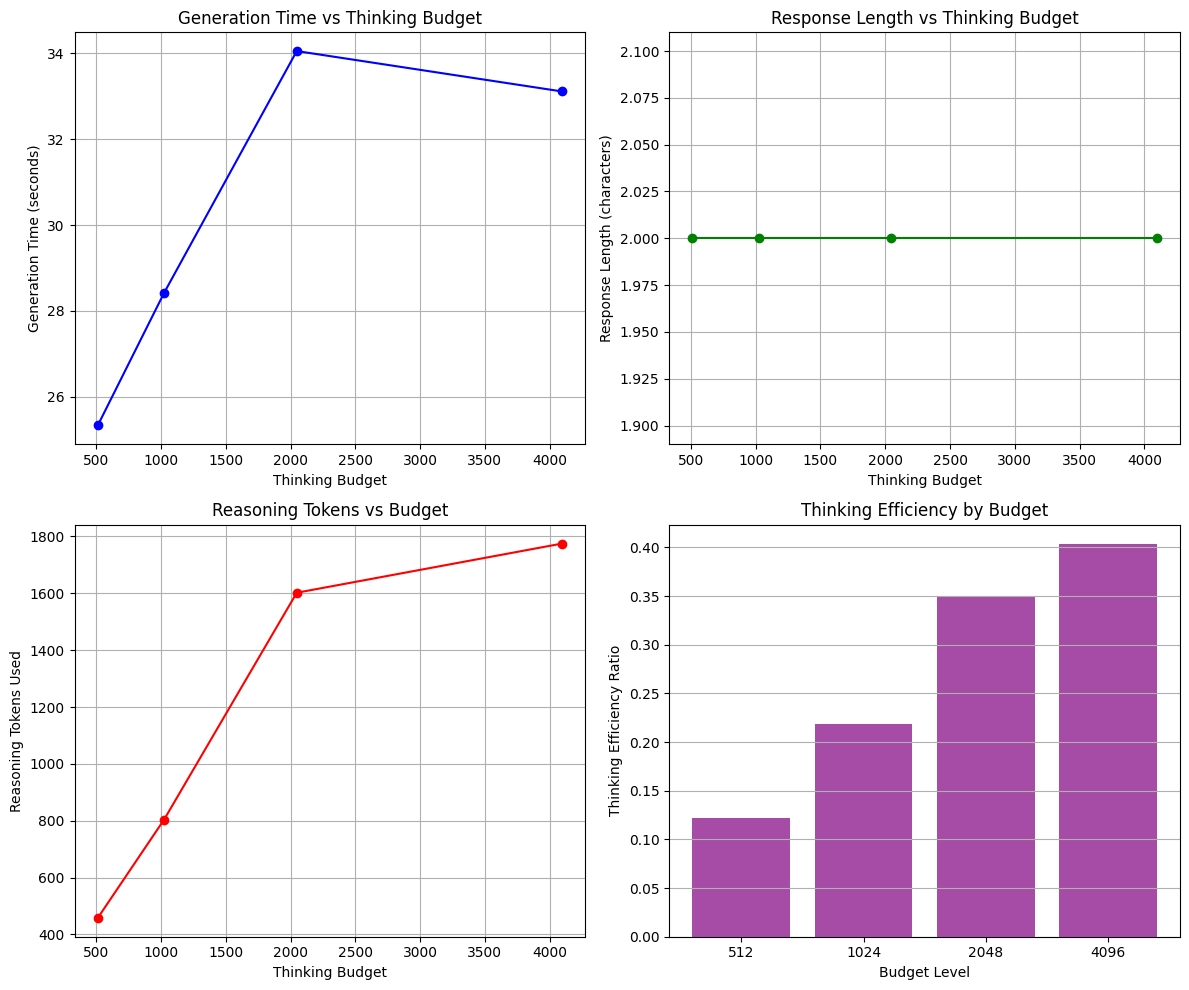

In [11]:
# Visualize the thinking performance metrics
analyzer.visualize_thinking_performance(analysis_results)

This monitoring and debugging framework provides comprehensive insights into how thinking capabilities perform across different scenarios. The analysis tools help identify optimal thinking budgets for specific types of problems and reveal patterns in how the model utilizes its reasoning capabilities.